In [1]:
import os, sys
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression


In [2]:
# context manager to suppress stdoutm for annoying long printouts
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
experiment = 'tf_resnet50'
batch_size = 300

In [4]:
platform = 'paperspace' #@param ['colab', 'paperspace'] {allow-input: true}

if platform == 'jupyter_notebook':
    challenge_data_dir = '../data/algonauts_2023_challenge_data'
    exp_output_dir = f'../data/out/{experiment}'

if platform == 'paperspace':
    challenge_data_dir = '/storage/algonauts_2023_challenge_data'
    exp_output_dir = f'../data/out/{experiment}'

## Functions not aligned with the current structuree

In [5]:
def train_pca(model, train_dataset):
    
    features = []
    for batch in train_dataset:
        # Extract features
        with HiddenPrints():
            ft = model.predict(batch)
        # Flatten the features
        ft = ft.reshape(ft.shape[0], -1)
        # Append to list
        features.append(ft)
    # Combine features from all batches
    features = np.vstack(features)

    # Fit PCA to combined features
    pca = PCA(n_components=100)
    print('PCA fitting...')
    pca.fit(features)
    print('PCA over')
    # print('plot the explained variance')
    # plt.plot(pca.explained_variance_ratio_)
    # plt.show()
    # print('plot the cumulative explained variance')
    # plt.plot(np.cumsum(pca.explained_variance_ratio_))
    # plt.show()
    return pca

def extract_and_transform_features(dataset, model, pca):
    features = []
    for batch in dataset:
        with HiddenPrints():
            ft = model.predict(batch)
        # Flatten the features
        ft = ft.reshape(ft.shape[0], -1)
        # Fit PCA to batch of features
        ft = pca.transform(ft)
        features.append(ft)
    return np.vstack(features)

def load_datasets(dataset):
    train_val_imgs_paths = [os.path.join(dataset.train_img_dir, img_name) for img_name in dataset.training_img_list]
    train_paths = [train_val_imgs_paths[i] for i in dataset.idxs_train]
    val_paths = [train_val_imgs_paths[i] for i in dataset.idxs_val]
    test_imgs_paths = [os.path.join(dataset.test_img_dir, img_name) for img_name in dataset.test_img_list]

    train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
    val_ds = tf.data.Dataset.from_tensor_slices(val_paths)
    test_ds = tf.data.Dataset.from_tensor_slices(test_imgs_paths)

    image_size = (224, 224)

    def load_image(image_path):
        # load image file
        img = tf.io.read_file(image_path)
        # decode image
        img = tf.image.decode_jpeg(img, channels=3)
        # resize image to a fixed shape
        img = tf.image.resize(img, image_size)
        return img
    
    def process(ds):
        ds = ds.map(load_image)
        ds = ds.map(tf.keras.applications.resnet50.preprocess_input)
        ds = ds.batch(batch_size)
        ds = ds.prefetch(tf.data.AUTOTUNE)
        return ds
    
    train_ds = process(train_ds)
    val_ds = process(val_ds)
    test_ds = process(test_ds)

    return train_ds, val_ds, test_ds

def save_predictions(lh_fmri_test_pred, rh_fmri_test_pred, subject_submission_dir):
    lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
    rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

    np.save(os.path.join(subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
    np.save(os.path.join(subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)

## Specify model and appropriate image preprocessing steps
Define a function to load and return the model, printing its layers.
Due to memory constraints, we will delete the model from memory in each loop. Here we first load it, print its
nodes and delete it.

In [6]:
def load_model():
    # Take models from here https://keras.io/api/applications/
    model = tf.keras.applications.ResNet50(weights='imagenet')
    return model

model = load_model()
print(*(layer.name for layer in model.layers), sep=' -> ')
del model

input_1 -> conv1_pad -> conv1_conv -> conv1_bn -> conv1_relu -> pool1_pad -> pool1_pool -> conv2_block1_1_conv -> conv2_block1_1_bn -> conv2_block1_1_relu -> conv2_block1_2_conv -> conv2_block1_2_bn -> conv2_block1_2_relu -> conv2_block1_0_conv -> conv2_block1_3_conv -> conv2_block1_0_bn -> conv2_block1_3_bn -> conv2_block1_add -> conv2_block1_out -> conv2_block2_1_conv -> conv2_block2_1_bn -> conv2_block2_1_relu -> conv2_block2_2_conv -> conv2_block2_2_bn -> conv2_block2_2_relu -> conv2_block2_3_conv -> conv2_block2_3_bn -> conv2_block2_add -> conv2_block2_out -> conv2_block3_1_conv -> conv2_block3_1_bn -> conv2_block3_1_relu -> conv2_block3_2_conv -> conv2_block3_2_bn -> conv2_block3_2_relu -> conv2_block3_3_conv -> conv2_block3_3_bn -> conv2_block3_add -> conv2_block3_out -> conv3_block1_1_conv -> conv3_block1_1_bn -> conv3_block1_1_relu -> conv3_block1_2_conv -> conv3_block1_2_bn -> conv3_block1_2_relu -> conv3_block1_0_conv -> conv3_block1_3_conv -> conv3_block1_0_bn -> conv3_bloc

## Select layers and subjects
Now let's define which layer(s) we will pick from, and which subject(s) to process

In [7]:
layers = ['conv5_block2_out']
subjects = [1] #, 2, 3, 4, 5, 6, 7, 8]


## Run pipeline

Running for layer conv5_block2_out
Running for subject 1
Training images: 9841
Test images: 159
LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)
Training images: 9841
Test images: 159
Training stimulus images: 8856

Validation stimulus images: 985

Test stimulus images: 159
PCA fitting...
PCA over


100%|██████████| 20544/20544 [00:02<00:00, 8011.57it/s]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Layer: conv5_block2_out Subject: 1
LH Correlation: 0.4382729128636649 RH Correlation: 0.44117807807941134
LH median roi correlation: ['V1v: 0.4708444804460299', 'V1d: 0.48283774483615116', 'V2v: 0.4534633291507335', 'V2d: 0.43730261649707114', 'V3v: 0.4563816949320269', 'V3d: 0.44664180886264526', 'hV4: 0.43106013785199565', 'EBA: 0.5052895471761065', 'FBA-1: 0.42362764737253', 'FBA-2: nan', 'mTL-bodies: nan', 'OFA: 0.4147509810082306', 'FFA-1: 0.5024734217343485', 'FFA-2: nan', 'mTL-faces: nan', 'aTL-faces: nan', 'OPA: 0.4862703209482913', 'PPA: 0.47786871213308346', 'RSC: 0.5894906208079838', 'OWFA: 0.40443034893002777', 'VWFA-1: 0.41004288085355517', 'VWFA-2: 0.30725619833885803', 'mfs-words: 0.33370781922719606', 'mTL-words: nan', 'early: 0.42256147012351736', 'midventral: 0.4487246227062261', 'midlateral: 0.4033491118777195', 'midparietal: 0.5042935925535645', 'ventral: 0.40341794002545867', 'lateral: 0.4972850777573509', 'parietal: 0.4315777951274912', 'All vertices: 0.4382729128

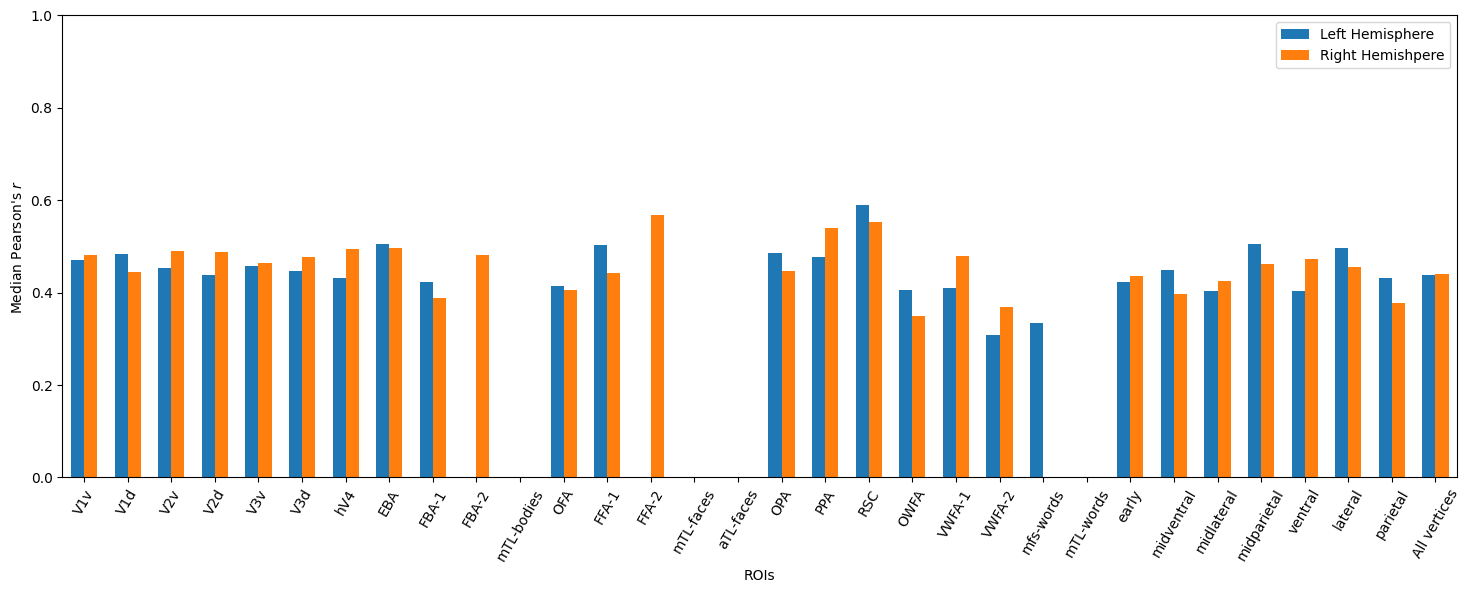

In [8]:
from pathlib import Path
from src.algonauts.evaluators import Correlations
from src.algonauts.data_processors.NSDDataset import NSDDataset

for layer_name in layers:
    print(f'Running for layer {layer_name}')
    for subj in subjects:
        print(f'Running for subject {subj}')

        # Set data directories based on parameters
        output_dir = f'{exp_output_dir}/{layer_name}'
        dataset = NSDDataset(challenge_data_dir, output_dir, subj)

        train_ds, val_ds, test_ds = load_datasets(dataset)
        
        # Load model for the iteration
        model = load_model()
        sliced_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

        # Train PCA
        pca = train_pca(sliced_model, train_ds)

        # Extract and transform features
        train_features = extract_and_transform_features(train_ds, sliced_model, pca)
        val_features = extract_and_transform_features(val_ds, sliced_model, pca)
        test_features = extract_and_transform_features(test_ds, sliced_model, pca)

        # Delete model to free up memory
        del model, pca

        # Fit regression
        reg_lh = LinearRegression().fit(train_features, dataset.lh_fmri_train)
        reg_rh = LinearRegression().fit(train_features, dataset.rh_fmri_train)
        
        # Use fitted linear regressions to predict the validation and test fMRI data
        lh_fmri_val_pred = reg_lh.predict(val_features)
        lh_fmri_test_pred = reg_lh.predict(test_features)
        rh_fmri_val_pred = reg_rh.predict(val_features)
        rh_fmri_test_pred = reg_rh.predict(test_features)
        # Calculate correlations for each hemisphere
        lh_correlation = Correlations.calculate_correlation(lh_fmri_val_pred, dataset.lh_fmri_val)
        rh_correlation = Correlations.calculate_correlation(rh_fmri_val_pred, dataset.rh_fmri_val)  
    
        Correlations.plot_and_write_correlations(dataset, lh_correlation, rh_correlation, exp_output_dir, layer_name, subj)
        save_predictions(lh_fmri_test_pred, rh_fmri_test_pred, dataset.subject_submission_dir)